In [1]:
import cnn
import xarray as xr
import numpy as np
import torch
import torch.nn as nn
import einops
import matplotlib.pyplot as plt
import sklearn.metrics as skl

In [2]:
from sklearn.utils import shuffle
from tqdm import tqdm
from IPython.display import clear_output


In [3]:
#ds_first = xr.open_dataset('example_data/dummy_data.nc', engine='netcdf4')
ds = xr.open_dataset('example_data/dummy_data.nc', engine='netcdf4')
ds = ds.rename({'time': 'timestep'})

In [4]:
last_hour = range(-1,-60,-1)
# ds['wet_radar'] = ds.radar.isel(timestep=last_hour).sum(dim='timestep')>0.1
ds['radar'] = ds.tl.isel(channel_id = 0)
ds['wet_radar'] = ds.radar.isel(timestep=last_hour).sum(dim='timestep')>32


In [5]:
ds

<xarray.Dataset> Size: 432kB
Dimensions:    (sample_number: 100, channel_id: 2, timestep: 180)
Dimensions without coordinates: sample_number, channel_id, timestep
Data variables:
    tl         (sample_number, channel_id, timestep) float64 288kB ...
    radar      (sample_number, timestep) float64 144kB ...
    wet_radar  (sample_number) bool 100B False False False ... False True False

In [6]:
'''
def balance_classes(a, boo):
    lsn=len(a.sample_number)
    ind = np.arange(lsn)
    ind_true = shuffle(ind[boo])
    ind_false = ind[~boo]
    ind_true = ind_true[:np.sum(~boo)]
    print(1-(2*len(ind_false)/lsn))
    return a.isel(sample_number=np.concatenate([ind_true,ind_false]))
'''

'\ndef balance_classes(a, boo):\n    lsn=len(a.sample_number)\n    ind = np.arange(lsn)\n    ind_true = shuffle(ind[boo])\n    ind_false = ind[~boo]\n    ind_true = ind_true[:np.sum(~boo)]\n    print(1-(2*len(ind_false)/lsn))\n    return a.isel(sample_number=np.concatenate([ind_true,ind_false]))\n'

In [7]:
#ds = balance_classes(ds, ~ds.wet_radar.values)

In [8]:
# ds = ds.isel(sample_number=np.arange(24))

In [9]:
ds['tl'] = ds.tl.transpose('sample_number', 'channel_id', 'timestep')

In [10]:
batchsize = 10
working_size = int(len(ds.sample_number)*0.8/batchsize)* batchsize

In [11]:
working_size

80

In [12]:
tl, wr = shuffle(ds.tl.values, ds.wet_radar.values)

data = tl[:working_size]
data_test = tl[working_size:]
data_out = wr[:working_size]
data_test_out = wr[working_size:]

In [13]:
np.histogram(data_test_out)

C:\Users\lukas\AppData\Local\Temp\ipykernel_7772\2312033233.py:1: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  np.histogram(data_test_out)


(array([17,  0,  0,  0,  0,  0,  0,  0,  0,  3]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

bsp zum "abrunden" auf ganze batch size
`data = data[:int(len(data/batch_size))*batch_size]`

In [14]:

### data as Tensor
data = torch.Tensor(data)
data_test = torch.Tensor(data_test)

data_out = torch.Tensor(data_out)
data_test_out = torch.Tensor(data_test_out)


In [15]:

### prepare data
dataset = torch.utils.data.TensorDataset(data, data_out)
testset = torch.utils.data.TensorDataset(data_test, data_test_out)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batchsize, shuffle = False)


In [16]:
model = cnn.cnn_class()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)


In [17]:
epochs = 30
resume = 0

In [18]:
if resume == 0:
    loss_dict = {}
    loss_dict['train'] = {}
    loss_dict['test'] = {}
    for key in ['train','test']:
        loss_dict[key]['loss'] = []

In [19]:
len(dataset)

80

29

train loss: 0.36194092
test loss: 0.40332076
min test loss: 0.3604175


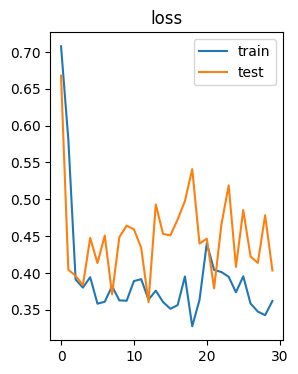

In [20]:
for epoch in range(resume, epochs):
    # training
    train_losses = []
    for inputs, targets in tqdm(trainloader):
        optimizer.zero_grad()
        # print(len(targets[0]))
        # x
        pred = model(inputs)
        # print(len(pred[0]))
        # x
        
        pred = nn.Flatten(0,1)(pred)
        loss = nn.BCELoss()(pred, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    loss_dict['train']['loss'].append(np.mean(train_losses))
    
    # testing
    test_losses = []
    with torch.no_grad():
        for inputs, targets in tqdm(testloader):
            pred = model(inputs)
            # pred = pred.round()
            pred = nn.Flatten(0,1)(pred)
            loss = nn.BCELoss()(pred, targets)
            test_losses.append(loss.detach().numpy())
        loss_dict['test']['loss'].append(np.mean(test_losses))
        
    # printing
    clear_output(wait=True)
    print(epoch)
    print('')
    print('train loss:', np.mean(train_losses))
    print('test loss:', np.mean(test_losses))
    print('min test loss:', np.min(loss_dict['test']['loss']))
    fig, axs = plt.subplots(1,1, figsize=(3,4))
    for key in loss_dict.keys():
        for k, key2 in enumerate(loss_dict[key].keys()):
            axs.plot(loss_dict[key][key2], label=key)
            axs.set_title(key2)
    # axs.set_yscale('log')
    plt.legend()
    plt.show()
    resume = epoch

In [21]:
for inputs, targets in tqdm(trainloader):
    print(model(inputs))
    break

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

tensor([[0.1448],
        [0.2222],
        [0.0726],
        [0.1126],
        [0.0938],
        [0.1275],
        [0.0776],
        [0.0989],
        [0.0792],
        [0.0828]], grad_fn=<SigmoidBackward0>)


In [22]:
### accuracy score, confusion matrix and Matthews correlation coefficient (MCC)
def eval_model(test_dataloader, model):
    predictions, actuals = list(), list()
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader):
            pred = model(inputs)
            pred = pred.detach().numpy()
            actual = targets.numpy()
            actual = actual.reshape((len(actual), 1))
            pred = pred.round()
    
            predictions.append(pred)
            actuals.append(actual)
    predictions, actuals = np.ravel(np.vstack(predictions)), np.ravel(np.vstack(actuals))
    acc = skl.accuracy_score(actuals, predictions)
    conf_mat = skl.confusion_matrix(actual, pred, labels=[0,1], normalize='all')
    matt_cor = skl.matthews_corrcoef(actual, pred)
    return acc, conf_mat, matt_cor

In [23]:
eval_model(testloader, model)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 100.05it/s]
D:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


(0.85,
 array([[1., 0.],
        [0., 0.]]),
 0.0)